<a href="https://colab.research.google.com/github/Sara-Esm/Natural-Language-Processing-NLP-and-generative-AI/blob/main/6_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Text Classification Using BERT Transformers

This project uses BERT transformers to classify U.S. economic news headlines. The workflow includes text preprocessing, tokenization with BERT's tokenizer, and fine-tuning a transformer-based model to determine whether a headline is relevant or not to the U.S. economy.

In [33]:
## Install Libraries

# Install necessary libraries
!pip install transformers tensorflow matplotlib seaborn

In [34]:
## Downloading and Loading the Dataset

import kagglehub
import pandas as pd

# Suppress TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Download latest version
path = kagglehub.dataset_download("heeraldedhia/us-economic-news-articles")
print("Dataset downloaded to:", path)

# Load the dataset
news_df = pd.read_csv(f"/root/.cache/kagglehub/datasets/heeraldedhia/us-economic-news-articles/versions/2/US-Economic-News.csv", encoding='ISO-8859-1', nrows=1000)[["text", "relevance"]]

# Display the first few rows of the dataset
news_df

Dataset downloaded to: /root/.cache/kagglehub/datasets/heeraldedhia/us-economic-news-articles/versions/2


,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,yes
1,The Wall Street Journal Online</br></br>The Mo...,no
2,WASHINGTON -- In an effort to achieve banking ...,no
3,The statistics on the enormous costs of employ...,no
4,NEW YORK -- Indecision marked the dollar's ton...,yes
...,...,...
995,Banks are boosting their lending to businesses...,yes
996,Drug maker Merck is hoping it can reenter a lu...,no
997,When electricity deregulation rolled out in Te...,no
998,"In Wall Street's leading corporate drama, it's...",yes


In [35]:
# Preprocess relevance column
news_df = news_df[news_df.relevance != "not sure"]  # Filter out irrelevant rows
news_df['relevance'] = news_df.relevance.map({'yes': 1, 'no': 0})  # Map 'yes' to 1, 'no' to 0

<ipython-input-35-4151763f0013>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_df['relevance'] = news_df.relevance.map({'yes': 1, 'no': 0})  # Map 'yes' to 1, 'no' to 0


Text(0.5, 1.0, 'Pie chart of Relevance')

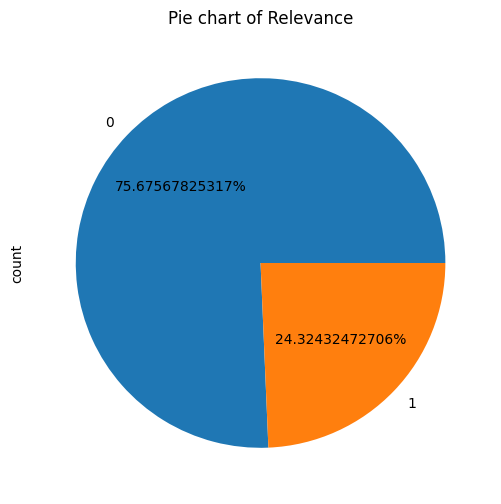

In [36]:
# Create a pie chart
import matplotlib.pyplot as plt
m = news_df['relevance'].value_counts()
m.plot(kind ='pie', autopct = '%1.11f%%', figsize = (12,6))
plt.title('Pie chart of Relevance')

In [37]:
news_df.iloc[0]["text"]

'NEW YORK -- Yields on most certificates of deposit offered by major banks dropped more than a tenth of a percentage point in the latest week, reflecting the overall decline in short-term interest rates.</br></br>On small-denomination, or "consumer," CDs sold directly by banks, the average yield on six-month deposits fell to 5.49% from 5.62% in the week ended yesterday, according to an 18-bank survey by Banxquote Money Markets, a Wilmington, Del., information service.</br></br>On three-month "consumer" deposits, the average yield sank to 5.29% from 5.42% the week before, according to Banxquote. Two banks in the Banxquote survey, Citibank in New York and CoreStates in Pennsylvania, are paying less than 5% on threemonth small-denomination CDs.</br></br>Declines were somewhat smaller on five-year consumer CDs, which eased to 7.37% from 7.45%, Banxquote said.</br></br>Yields on three-month and six-month Treasury bills sold at Monday\'s auction plummeted more than a fifth of a percentage po

In [38]:
# Clean text using custom preprocessing (e.g., removing special characters)
import string
import spacy

nlp = spacy.load('en_core_web_sm')

def clean_text(doc):
    # Remove named entities, special characters, and stopwords
    doc = nlp(doc)
    text_no_namedentities = [word.text for word in doc if not word.ent_type_]
    doc = " ".join(text_no_namedentities)

    # Further cleaning
    doc = doc.lower().strip()
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    return doc

# Apply cleaning to the text column
news_df['text'] = news_df['text'].apply(clean_text)

<ipython-input-38-203ffb23576c>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_df['text'] = news_df['text'].apply(clean_text)


In [39]:
news_df.head()

,text,relevance
0,yields on most certificates of deposit offere...,1
1,onlinebrbr a look at the s biggest news is ...,0
2,in an effort to achieve banking reform negot...,0
3,the statistics on the enormous costs of employ...,0
4,indecision marked the dollar s tone as trade...,1


In [41]:
## Tokenization and Encoding

from transformers import BertTokenizer
import numpy as np

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts,
        return_attention_masks=False,
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    return np.array(enc_di['input_ids'])

# Tokenize the dataset
X = regular_encode(news_df['text'], tokenizer)

# Split dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, news_df["relevance"], test_size=0.2, random_state=42)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_atte

In [42]:
## Build the BERT Model

import tensorflow as tf
from transformers import TFAutoModel

def build_model(transformer, loss='binary_crossentropy', max_len=512):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    x = tf.keras.layers.Dropout(0.3)(cls_token)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=input_word_ids, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-5), loss=loss, metrics=['accuracy'])
    return model

# Load BERT model
transformer_layer = TFAutoModel.from_pretrained('bert-base-uncased')

# Build the model
model = build_model(transformer_layer, max_len=512)
model.summary()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 512)]             0         
 )                                                               
                                                                 
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPo   109482240 
 )                           olingAndCrossAttentions             
                             (last_hidden_state=(Non             
                             e, 512, 768),                       
                              pooler_output=(None, 7             
                             68),                                
                              past_key_values=None,              
                             hidden_states=None, att             
                             entions=None, cross_att             
                             entions=None)                   

In [46]:
## Train the Mode

# Prepare datasets for training
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(4)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)

# Train the model
history = model.fit(train_dataset, epochs=5, steps_per_epoch=len(X_train)//4)

Epoch 1/5
 15/199 [=>............................] - ETA: 1:34:36 - loss: 0.5861 - accuracy: 0.7500

KeyboardInterrupt: 

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 512)]            0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  109482240
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             512, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

In [ ]:
## Evaluate the Model

# Generate predictions
predictions = model.predict(test_dataset, verbose=1)
predictions_rounded = np.round(predictions).astype(int)

# Classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, predictions_rounded))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, predictions_rounded)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
